In [2]:
# Import libraries
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
import matplotlib.pyplot as plt



In [3]:
# Load data from NASA C-MAPSS
# Ensure the train_FD001.txt file is in the same directory
try:
    columns = ['unit_number', 'time_cycle'] + [f'oper_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
    data = pd.read_csv('/content/sample_data/train_FD001.txt', sep=' ', header=None, names=columns)  # Adjusted path
except FileNotFoundError:
    print("Error: 'train_FD001.txt' not found. Please download the file from NASA Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) and place it in the same directory.")
    exit()

# Remove empty columns
data = data.dropna(axis=1, how='all')
# Calculate RUL (Remaining Useful Life)
data['max_cycle'] = data.groupby('unit_number')['time_cycle'].transform('max')
data['RUL'] = data['max_cycle'] - data['time_cycle']

# Select features (Sensors) and target (RUL)
X = data[[f'sensor_{i}' for i in range(1, 20)]]  # Sensor measurements
y = data['RUL']  # Target (RUL)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:

# Split the data based on units to avoid data leakage
units = data['unit_number'].unique()
train_units, test_units = train_test_split(units, test_size=0.2, random_state=42)
train_mask = data['unit_number'].isin(train_units)
test_mask = data['unit_number'].isin(test_units)

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [5]:

# Initialize a list to store results
results = []

# 1. Random Forest
print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred) * 100
results.append(['Random Forest', rf_r2, rf_rmse, rf_time])


Training Random Forest...


In [6]:

# 2. SVM
print("Training SVM...")
start_time = time.time()
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_time = time.time() - start_time
svm_pred = svm_model.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_pred))
svm_r2 = r2_score(y_test, svm_pred) * 100
results.append(['SVM', svm_r2, svm_rmse, svm_time])


Training SVM...


In [7]:

# 3. XGBoost
print("Training XGBoost...")
start_time = time.time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred) * 100
results.append(['XGBoost', xgb_r2, xgb_rmse, xgb_time])


Training XGBoost...


In [ ]:

# 4. LSTM
print("Training LSTM...")
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
start_time = time.time()
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
lstm_time = time.time() - start_time
lstm_pred = lstm_model.predict(X_test_lstm, verbose=0)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_r2 = r2_score(y_test, lstm_pred) * 100
results.append(['LSTM', lstm_r2, lstm_rmse, lstm_time])



Training LSTM...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 3.5435e-05
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9800e-06
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 1.0696e-06
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 6.3779e-07
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 4.6349e-07
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 3.0743e-07
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 2.4020e-07
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 1.9905e-07
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 1.6033e-07
Epoch 10/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 1.5763e-07
Epoch 11/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 1.3840e-07
Epoch 12/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.4176e-07
Epoch 13/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 1.2880e-07
Epoch 14/20


In [9]:
# 5. CNN
print("Training CNN...")
start_time = time.time()
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
cnn_time = time.time() - start_time
cnn_pred = cnn_model.predict(X_test_lstm, verbose=0)
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_pred))
cnn_r2 = r2_score(y_test, cnn_pred) * 100
results.append(['CNN', cnn_r2, cnn_rmse, cnn_time])



Training CNN...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0016
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.7973e-07
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7842e-07
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0624e-07
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0000e-07
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.3182e-08
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.9662e-08
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.8805e-08
Epoch 9/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.9606e-08
Epoch 10/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.8376e-08
Epoch 11/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.2307e-08
Epoch 12/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.0744e-08
Epoch 13/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.2560e-08
Epoch 14/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.2359e-08
Epoch 15/20
525/


Algorithm Comparison Table:
       Algorithm  R^2 Score (%)      RMSE  Training Time (s)
0  Random Forest      -3.363173  0.000305          51.190114
1            SVM      -3.529357  0.000305           0.014248
2        XGBoost      -0.042260  0.000300           0.109614
3           LSTM      -3.615132  0.000305         342.766453
4            CNN     -16.292581  0.000323          62.460263


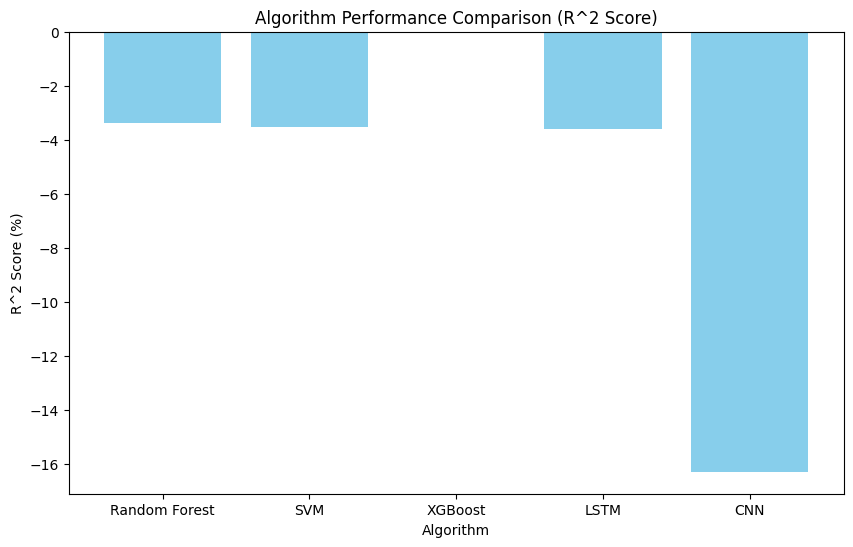

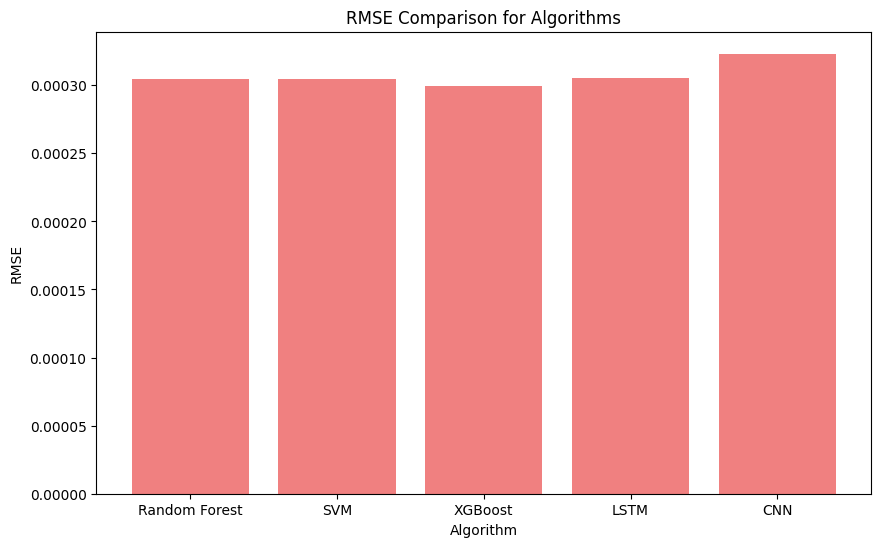

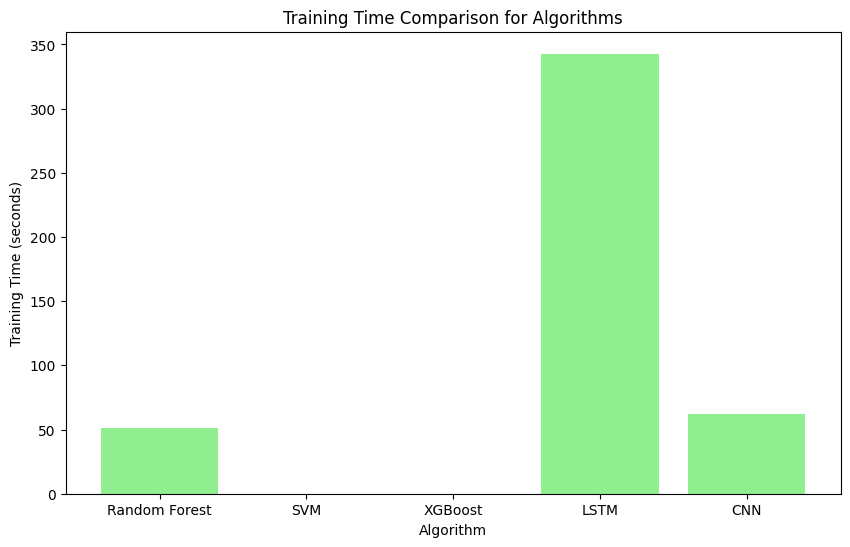

In [10]:
# Display results in a table
results_df = pd.DataFrame(results, columns=['Algorithm', 'R^2 Score (%)', 'RMSE', 'Training Time (s)'])
print("\nAlgorithm Comparison Table:")
print(results_df)

# Plot R^2 Score comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algorithm'], results_df['R^2 Score (%)'], color='skyblue')
plt.title('Algorithm Performance Comparison (R^2 Score)')
plt.xlabel('Algorithm')
plt.ylabel('R^2 Score (%)')
plt.savefig('r2_score_comparison.png')
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algorithm'], results_df['RMSE'], color='lightcoral')
plt.title('RMSE Comparison for Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.savefig('rmse_comparison.png')
plt.show()

# Plot Training Time comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Algorithm'], results_df['Training Time (s)'], color='lightgreen')
plt.title('Training Time Comparison for Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Training Time (seconds)')
plt.savefig('training_time_comparison.png')
plt.show()